In [102]:
# === LSTM TREND CLASSIFICATION (LIU ET AL.) FOR ADANIENT–ADANIPORTS ===

import pandas as pd
import numpy as np
import ta
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

In [103]:
def load_stock_csv(path, suffix):
    df = pd.read_csv(path, header=[0, 1], index_col=0, parse_dates=True)
    df.columns = df.columns.get_level_values(0)
    return df.rename(columns={col: f"{col}_{suffix}" for col in df.columns})

ent = load_stock_csv("Adani_Enterprises_1min.csv", "A")
ports = load_stock_csv("Adani_Ports_1min.csv", "B")
df = pd.concat([ent, ports], axis=1).dropna()



In [104]:
# === 1. Load CSVs with MultiIndex headers and flatten ===
adanient = pd.read_csv("Adani_Enterprises_1min.csv", header=[0, 1], index_col=0, parse_dates=True)
adaniports = pd.read_csv("Adani_Ports_1min.csv", header=[0, 1], index_col=0, parse_dates=True)

# Flatten to keep 'Close', 'Open', etc.
adanient.columns = adanient.columns.get_level_values(0)
adaniports.columns = adaniports.columns.get_level_values(0)

# Rename columns for clarity
adanient = adanient.rename(columns={
    'Close': 'Close_A',
    'Volume': 'Volume_A'
})
adaniports = adaniports.rename(columns={
    'Close': 'Close_B',
    'Volume': 'Volume_B'
})

# === 2. Align and combine ===
adani = pd.concat([adanient[['Close_A', 'Volume_A']], 
                   adaniports[['Close_B', 'Volume_B']]], axis=1).dropna()


In [105]:


# === 3. Calculate spread Z = A - beta * B ===
import statsmodels.api as sm
X = sm.add_constant(adani['Close_B'])
beta = sm.OLS(adani['Close_A'], X).fit().params['Close_B']
adani['Z'] = adani['Close_A'] - beta * adani['Close_B']

# === 4. Feature Engineering ===
adani['Z_10MA'] = adani['Z'].rolling(10).mean()
adani['Z_20MA'] = adani['Z'].rolling(20).mean()
adani['Z_30MA'] = adani['Z'].rolling(30).mean()
adani['Z_RSI'] = ta.momentum.RSIIndicator(close=adani['Z'], window=14).rsi()
adani['Z_MACD'] = ta.trend.MACD(close=adani['Z']).macd_diff()
adani.dropna(inplace=True)

In [107]:
# === 5. Labeling using 4 consecutive highs/lows ===
adani['Trend'] = 1  # Default to neutral
for i in range(4, len(adani)):
    z_slice = adani['Z'].iloc[i-4:i].values
    if all(z_slice[j] < z_slice[j+1] for j in range(3)):
        adani.at[adani.index[i], 'Trend'] = 2  # Uptrend
    elif all(z_slice[j] > z_slice[j+1] for j in range(3)):
        adani.at[adani.index[i], 'Trend'] = 0  # Downtrend


In [108]:
from sklearn.utils.class_weight import compute_class_weight

# === 6. Normalize features ===
features = ['Z', 'Z_10MA', 'Z_20MA', 'Z_30MA', 'Volume_A', 'Volume_B', 'Z_RSI', 'Z_MACD']
scaler = StandardScaler()
X_scaled = scaler.fit_transform(adani[features])
y = adani['Trend'].values

# Compute class weights (based only on training set labels)
classes = np.unique(y)
split = int(0.7 * len(y))  # Use the same split as the model
class_weights = compute_class_weight(class_weight='balanced', classes=classes, y=y[:split])
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float32)


In [109]:

# === 7. Create sequences ===
def create_sequences(X, y, seq_len):
    Xs, ys = [], []
    for i in range(len(X) - seq_len):
        Xs.append(X[i:i+seq_len])
        ys.append(y[i+seq_len])
    return np.array(Xs), np.array(ys)

seq_len = 30
X_seq, y_seq = create_sequences(X_scaled, y, seq_len)

# === 8. Dataset and Dataloader ===
class TrendDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)
    def __len__(self): return len(self.X)
    def __getitem__(self, idx): return self.X[idx], self.y[idx]

split = int(0.7 * len(X_seq))
train_loader = DataLoader(TrendDataset(X_seq[:split], y_seq[:split]), batch_size=32, shuffle=True)
val_loader = DataLoader(TrendDataset(X_seq[split:], y_seq[split:]), batch_size=32)

In [110]:
# === 9. LSTM Model ===
class LSTMTrendClassifier(nn.Module):
    def __init__(self, input_size, hidden_size=64, num_classes=3):
        super().__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)
    def forward(self, x):
        _, (h_n, _) = self.lstm(x)
        return self.fc(h_n[-1])

model = LSTMTrendClassifier(input_size=len(features)).to("cpu")
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

In [111]:
# === 10. Training ===
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

for epoch in range(50):
    model.train()
    total_train_loss = 0
    for xb, yb in train_loader:
        optimizer.zero_grad()
        pred = model(xb)
        loss = loss_fn(pred, yb)
        loss.backward()
        optimizer.step()
        total_train_loss += loss.item()
    train_losses.append(total_train_loss / len(train_loader))

    model.eval()
    total_val_loss = 0
    with torch.no_grad():
        for xb, yb in val_loader:
            pred = model(xb)
            loss = loss_fn(pred, yb)
            total_val_loss += loss.item()
    val_losses.append(total_val_loss / len(val_loader))

    print(f"Epoch {epoch+1} | Train Loss: {train_losses[-1]:.4f} | Val Loss: {val_losses[-1]:.4f}")

    # Training Accuracy
    model.eval()
    correct_train, total_train = 0, 0
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        pred = model(xb)
        correct_train += (pred.argmax(1) == yb).sum().item()
        total_train += yb.size(0)
    train_accuracies.append(correct_train / total_train)

    # Validation Accuracy
    correct_val, total_val = 0, 0
    for xb, yb in val_loader:
        xb, yb = xb.to(device), yb.to(device)
        pred = model(xb)
        correct_val += (pred.argmax(1) == yb).sum().item()
        total_val += yb.size(0)
    val_accuracies.append(correct_val / total_val)




Epoch 1 | Train Loss: 1.0611 | Val Loss: 1.0480
Epoch 2 | Train Loss: 0.9388 | Val Loss: 0.8977
Epoch 3 | Train Loss: 0.6764 | Val Loss: 0.5495
Epoch 4 | Train Loss: 0.5702 | Val Loss: 0.5395
Epoch 5 | Train Loss: 0.5668 | Val Loss: 0.5396
Epoch 6 | Train Loss: 0.5681 | Val Loss: 0.5388
Epoch 7 | Train Loss: 0.5661 | Val Loss: 0.5371
Epoch 8 | Train Loss: 0.5691 | Val Loss: 0.5356
Epoch 9 | Train Loss: 0.5640 | Val Loss: 0.5355
Epoch 10 | Train Loss: 0.5622 | Val Loss: 0.5335
Epoch 11 | Train Loss: 0.5642 | Val Loss: 0.5336
Epoch 12 | Train Loss: 0.5626 | Val Loss: 0.5331
Epoch 13 | Train Loss: 0.5598 | Val Loss: 0.5320
Epoch 14 | Train Loss: 0.5549 | Val Loss: 0.5305
Epoch 15 | Train Loss: 0.5547 | Val Loss: 0.5297
Epoch 16 | Train Loss: 0.5486 | Val Loss: 0.5292
Epoch 17 | Train Loss: 0.5526 | Val Loss: 0.5278
Epoch 18 | Train Loss: 0.5467 | Val Loss: 0.5267
Epoch 19 | Train Loss: 0.5508 | Val Loss: 0.5267
Epoch 20 | Train Loss: 0.5506 | Val Loss: 0.5250
Epoch 21 | Train Loss: 0.5408

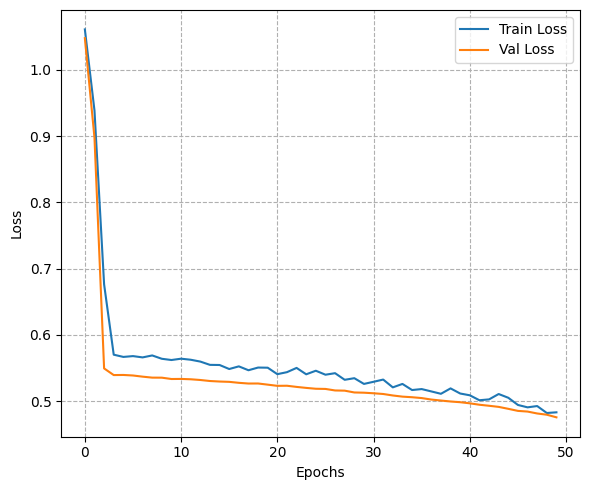

In [112]:

# === 11. Plot Loss ===
plt.figure(figsize=(6, 5))
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.grid(True, linestyle='--')
plt.legend()
plt.tight_layout()
plt.show()


C:\Users\mayur\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\mayur\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\mayur\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


              precision    recall  f1-score   support

        Down       0.00      0.00      0.00        60
     Neutral       0.84      1.00      0.91       744
          Up       0.00      0.00      0.00        78

    accuracy                           0.84       882
   macro avg       0.28      0.33      0.30       882
weighted avg       0.71      0.84      0.77       882



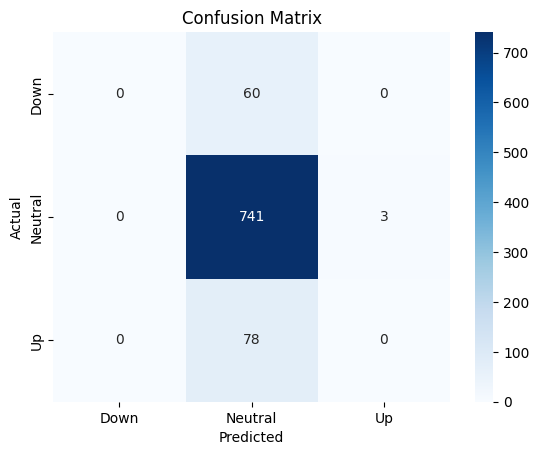

In [113]:

# === 12. Evaluate ===
preds, labels = [], []
model.eval()
with torch.no_grad():
    for xb, yb in val_loader:
        pred = model(xb).argmax(1).numpy()
        preds.extend(pred)
        labels.extend(yb.numpy())

print(classification_report(labels, preds, target_names=["Down", "Neutral", "Up"]))
sns.heatmap(confusion_matrix(labels, preds), annot=True, cmap="Blues", fmt='d',
            xticklabels=["Down", "Neutral", "Up"], yticklabels=["Down", "Neutral", "Up"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


In [114]:


# === 13. Save Model ===
torch.save(model.state_dict(), "lstm_adani_trend_model.pth")


In [53]:
print(classification_report(labels, preds, target_names=["Down", "Neutral", "Up"]))


              precision    recall  f1-score   support

        Down       0.47      0.43      0.45        60
     Neutral       0.88      0.94      0.91       744
          Up       0.50      0.23      0.32        78

    accuracy                           0.84       882
   macro avg       0.62      0.53      0.56       882
weighted avg       0.82      0.84      0.82       882



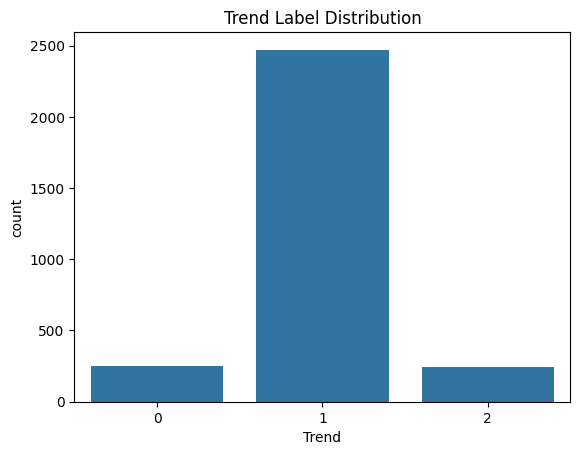

In [115]:
import seaborn as sns
sns.countplot(x=adani['Trend'])
plt.title("Trend Label Distribution")
plt.show()


In [116]:
adani["Trend"].value_counts()

Trend
1    2471
0     249
2     247
Name: count, dtype: int64

In [118]:
# === Plot Training Loss ===
def plot_training_curves(train_losses, val_losses):
    epochs = range(1, len(train_losses) + 1)
    plt.figure(figsize=(8, 5))
    plt.plot(epochs, train_losses, 'o-', label='train_loss')
    plt.plot(epochs, val_losses, 's-', label='test_loss')
    plt.xlabel("Epochs")
    plt.ylabel("Loss value")
    plt.title("(c)")
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()

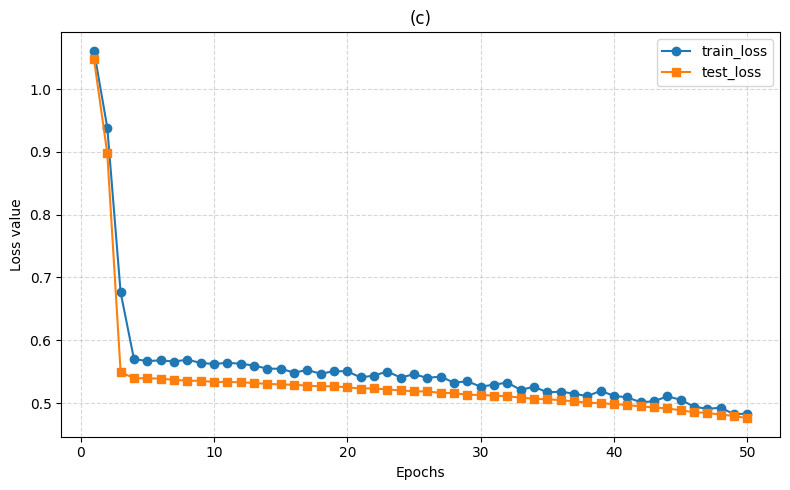

In [119]:
plot_training_curves(train_losses, val_losses)